## Data Collection and Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load dataset
df = pd.read_csv('Churn_Modelling.csv')

# Display the first few rows of the dataframe
df.head()

# Drop irrelevant columns
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

# Handle categorical variables
# OneHotEncode 'Geography' and 'Gender'
categorical_features = ['Geography', 'Gender']
numeric_features = df.columns.difference(categorical_features + ['Exited'])

# Define preprocess pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Define X and y
X = df.drop('Exited', axis=1)
y = df['Exited']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Convert transformed data back to DataFrame for EDA
encoded_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(numeric_features).tolist() + \
                        preprocessor.transformers_[1][1].get_feature_names_out(categorical_features).tolist()

X_train_df = pd.DataFrame(X_train, columns=encoded_feature_names)
X_test_df = pd.DataFrame(X_test, columns=encoded_feature_names)


## Exploratory Data Analysis (EDA)

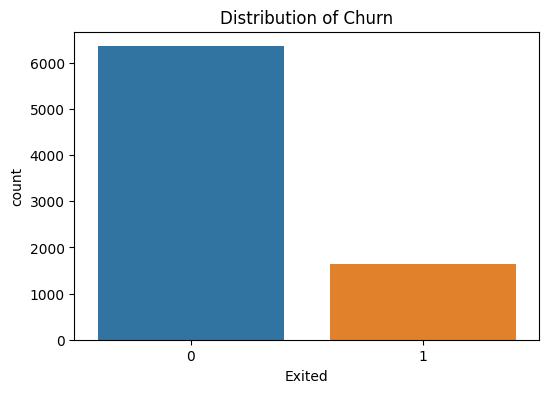

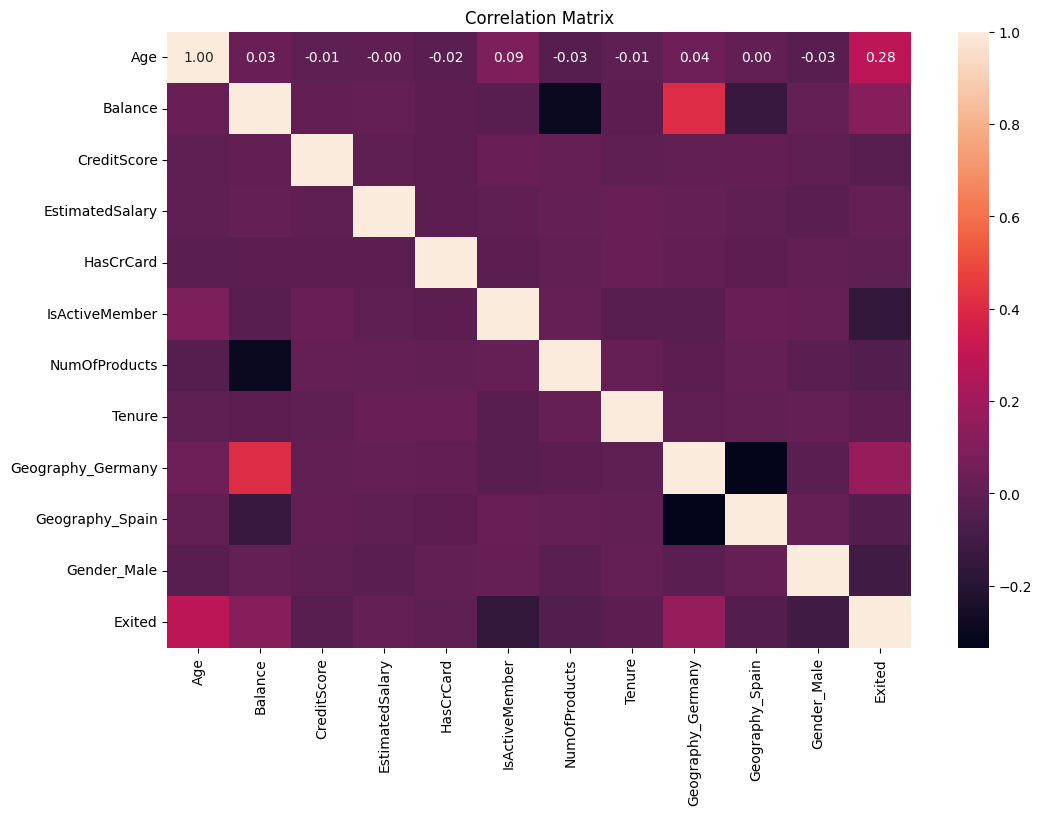

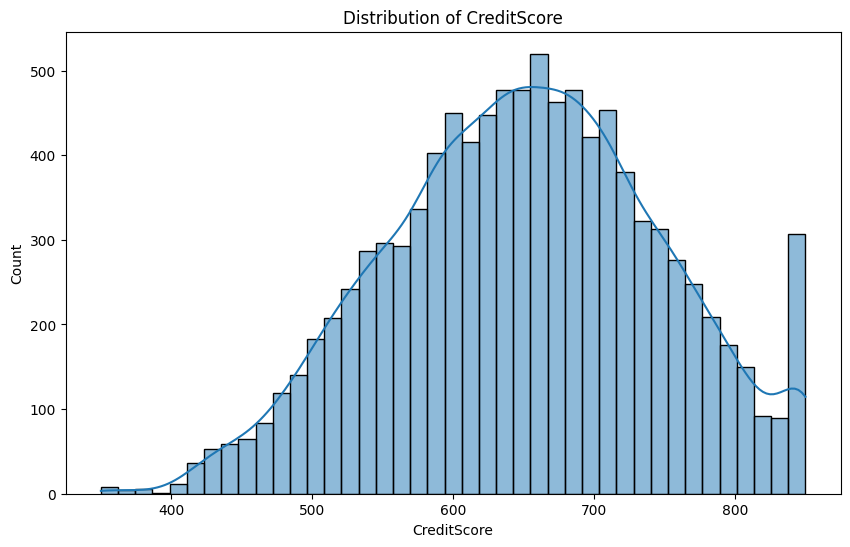

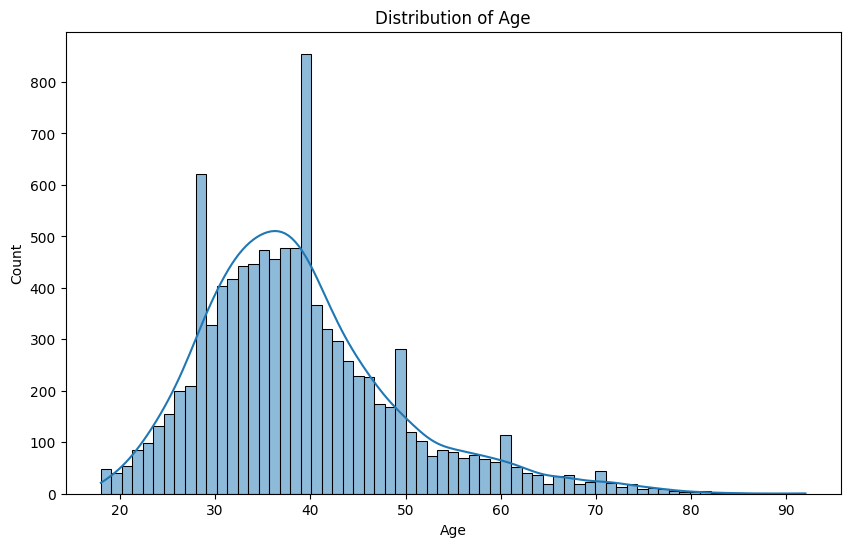

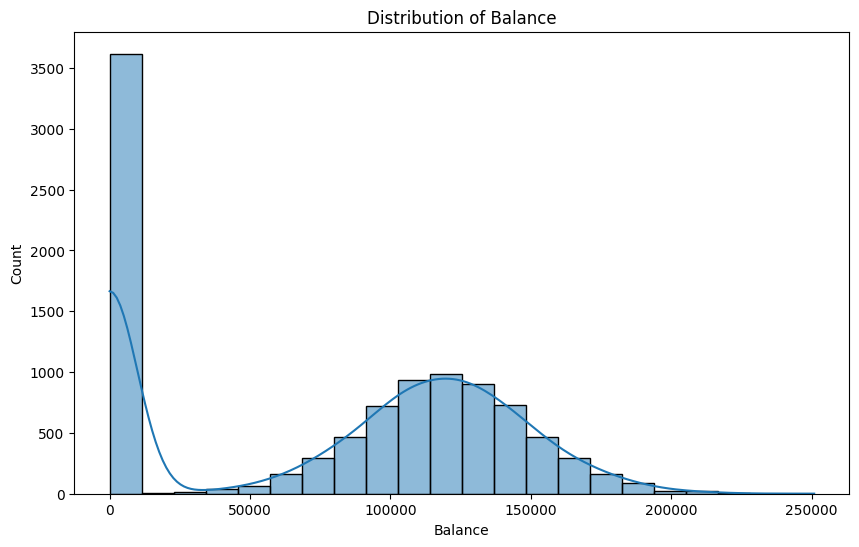

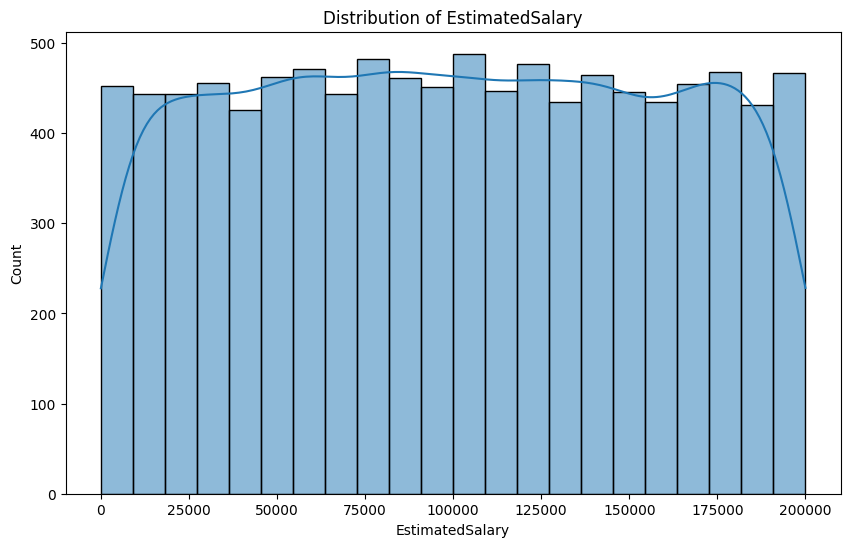

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the transformed data with the target variable for EDA
train_df = pd.concat([X_train_df, y_train.reset_index(drop=True)], axis=1)

# Plot the distribution of the target variable 'Exited'
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=train_df)
plt.title('Distribution of Churn')
plt.show()

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.corr(), annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Plot distributions of some key features
features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()


## Model Development

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import joblib

# Define a function to create the pipeline
def create_pipeline(model):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier',model)
    ])
    return pipeline

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

# Save the model and preprocessor
joblib.dump(best_rf,'churn_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

Fitting 3 folds for each of 27 candidates, totalling 81 fits


['preprocessor.pkl']

## Model Evaluation

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Logistic Regression Performance
y_pred_lr = lr.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")
print(f"Logistic Regression Precision: {precision_score(y_test, y_pred_lr):.2f}")
print(f"Logistic Regression Recall: {recall_score(y_test, y_pred_lr):.2f}")
print(f"Logistic Regression F1 Score: {f1_score(y_test, y_pred_lr):.2f}")
print(f"Logistic Regression AUC: {roc_auc_score(y_test, y_pred_lr):.2f}")

# Random Forest Performance
y_pred_rf = best_rf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Random Forest Precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Random Forest Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"Random Forest F1 Score: {f1_score(y_test, y_pred_rf):.2f}")
print(f"Random Forest AUC: {roc_auc_score(y_test, y_pred_rf):.2f}")

# XGBoost Performance
y_pred_xgb = xgb.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"XGBoost Precision: {precision_score(y_test, y_pred_xgb):.2f}")
print(f"XGBoost Recall: {recall_score(y_test, y_pred_xgb):.2f}")
print(f"XGBoost F1 Score: {f1_score(y_test, y_pred_xgb):.2f}")
print(f"XGBoost AUC: {roc_auc_score(y_test, y_pred_xgb):.2f}")

Logistic Regression Accuracy: 0.81
Logistic Regression Precision: 0.55
Logistic Regression Recall: 0.20
Logistic Regression F1 Score: 0.29
Logistic Regression AUC: 0.58
Random Forest Accuracy: 0.86
Random Forest Precision: 0.75
Random Forest Recall: 0.47
Random Forest F1 Score: 0.58
Random Forest AUC: 0.72
XGBoost Accuracy: 0.86
XGBoost Precision: 0.71
XGBoost Recall: 0.51
XGBoost F1 Score: 0.60
XGBoost AUC: 0.73
